In [26]:
import os
import tensorflow as tf
import numpy as np
import json

SEED = 1234
tf.random.set_seed(SEED)

In [27]:
#Creation of data generator objects

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='constant',#when we flip, rotate, we introduce new pixels and we must set a way on how to fill
                                       cval=0,
                                       rescale=1/255.)

else:
    train_data_gen = ImageDataGenerator(rescale=1/255.)
    
valid_data_gen = ImageDataGenerator(rescale=1/255.)


In [28]:
#Setting paths for training, validation and test set

cwd = os.path.join(os.path.dirname(os.getcwd()),"artificial-neural-networks-and-deep-learning-2020/MaskDataset/")

dataset_dir = os.path.join(cwd, "training/")
validation_dir = os.path.join(cwd, "validation/")
test_dir = os.path.join(cwd, "test/")

path = os.getcwd()
print ("The current working directory is %s" % test_dir)

with open(os.path.join(cwd,'train_gt.json')) as f:
  myJson = json.load(f)
print(myJson)

#division of images in different set

for key in myJson:
    os.rename(os.path.join(dataset_dir,key), dataset_dir+'/'+str(myJson[key])+'/'+key)

In [30]:
#Generators for reading images dirrectly from directories

img_h = 408
img_w = 612

bs=32

#training generator
train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(img_h,img_w),
                                              color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)
#validation generator
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                              batch_size=bs,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=SEED)


Found 5290 images belonging to 3 classes.
Found 324 images belonging to 3 classes.


In [92]:
#creation of dataset objects
num_classes = 3


train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

train_dataset=train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None,img_h,img_w,3],[None,num_classes]))

valid_dataset=valid_dataset.repeat()

In [93]:
import matplotlib.pyplot as plt

iterator = iter(train_dataset)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

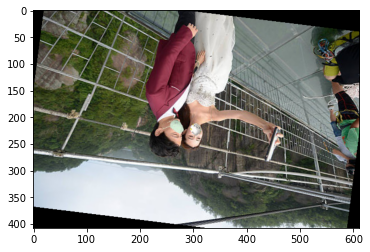

In [109]:
augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot

In [94]:
start_f = 16
depth = 6

model = tf.keras.Sequential()
for i in range(depth):
    if i == 0:
        input_shape = [img_h,img_w,3]
    else:
        input_shape = [None]
    
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='same',
                                    input_shape=input_shape))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    start_f *=2
    
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 408, 612, 16)      448       
_________________________________________________________________
re_lu_30 (ReLU)              (None, 408, 612, 16)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 204, 306, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 204, 306, 32)      4640      
_________________________________________________________________
re_lu_31 (ReLU)              (None, 204, 306, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 102, 153, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 102, 153, 64)     

In [95]:
#Loss function
loss = tf.keras.losses.CategoricalCrossentropy()

#Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Validation metric used during training
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [106]:
#Callbacks list

from datetime import datetime

exps_dir = os.path.join(cwd, 'classification_experiments_')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name='FC'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#Checkpoint callback
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'cp.ckpt'),save_weights_only=True)

callbacks.append(ckpt_callback)

#tensorboard callback
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
tb_callback=tf.keras.callbacks.TensorBoard(log_dir=tb_dir,histogram_freq=1)


# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)



In [120]:
model.load_weights(filepath=os.path.join(cwd,'cp.ckpt'))


model.fit(x=train_dataset,
         epochs=1,
         steps_per_epoch=len(train_gen),
        validation_data=valid_dataset,
         validation_steps=len(valid_gen),
         callbacks=callbacks)

Train for 166 steps, validate for 11 steps
166/166 [==============================] - 266s 2s/step - loss: 0.3176 - accuracy: 0.8599 - val_loss: 0.4421 - val_accuracy: 0.7901


In [121]:
#Function for creating the result in a csv file

from datetime import datetime

def create_csv(results, results_dir='./results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')




In [125]:
#Prediction computation done one image at time

from PIL import Image

image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:
    
    image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    
    predictions = model.predict_classes(input_arr*(1/255))
    #img = Image.open(test_dir+'/'+image_name).convert('RGB')
    #img_array = np.array(img)
    #img_array = np.expand_dims(img_array, 0) 
    #data_normalization
    #print(np.argmax(predictions, axis=1)[0] )

    #prediction = argmax(softmax)   # predicted class
    

    #results[image_name] = np.argmax(predictions, axis=1) [0]
    
    results[image_name] = predictions[0]

create_csv(results)
print (results)

{'10001.jpg': 1, '10040.jpg': 2, '10074.jpg': 1, '10084.jpg': 1, '10100.jpg': 2, '10120.jpg': 2, '10125.jpg': 1, '10148.jpg': 1, '10213.jpg': 1, '10239.jpg': 2, '10242.jpg': 1, '10259.jpg': 1, '10289.jpg': 1, '10296.jpg': 0, '10323.jpg': 1, '10324.jpg': 0, '10326.jpg': 1, '10328.jpg': 0, '10330.jpg': 0, '10346.jpg': 2, '10349.jpg': 1, '10370.jpg': 1, '10382.jpg': 1, '10396.jpg': 1, '10411.jpg': 1, '10437.jpg': 1, '10459.jpg': 0, '10473.jpg': 1, '10477.jpg': 1, '10494.jpg': 2, '10520.jpg': 2, '10530.jpg': 1, '10571.jpg': 1, '10572.jpg': 1, '10581.jpg': 2, '10620.jpg': 0, '10641.jpg': 1, '10643.jpg': 1, '10662.jpg': 0, '10691.jpg': 1, '10715.jpg': 1, '10727.jpg': 2, '10760.jpg': 0, '10771.jpg': 1, '10782.jpg': 2, '10800.jpg': 0, '10812.jpg': 1, '10845.jpg': 0, '10850.jpg': 2, '10853.jpg': 1, '10863.jpg': 2, '10873.jpg': 0, '10999.jpg': 1, '11012.jpg': 1, '11026.jpg': 0, '11045.jpg': 1, '11115.jpg': 0, '11130.jpg': 2, '11136.jpg': 1, '11137.jpg': 2, '11175.jpg': 1, '11176.jpg': 1, '11202.

In [63]:
model.save_weights(filepath=os.path.join(cwd,'cp.ckpt'))

In [50]:
print(cwd)

C:/Users/ASUS/Documents/Università/ANNDL


(1, 408, 612, 3)
[[[[0.06666667 0.03529412 0.02352941]
   [0.06666667 0.03529412 0.02352941]
   [0.07058824 0.04313726 0.01960784]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.06666667 0.03529412 0.02352941]
   [0.06666667 0.03921569 0.01568628]
   [0.07058824 0.04313726 0.01960784]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.06666667 0.03529412 0.02352941]
   [0.07058824 0.04313726 0.01960784]
   [0.07450981 0.04705882 0.02352941]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  ...

  [[0.00392157 0.00392157 0.        ]
   [0.00392157 0.00392157 0.        ]
   [0.00392157 0.00392157 0.        ]
   ...
   [0.20784314 0.06666667 0.00392157]
   [0.20784314 0.06666667 0.00392157]
   [0.20392157 0.0627451  0.        ]]

  [[0.00392157 0.00392157 0.

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

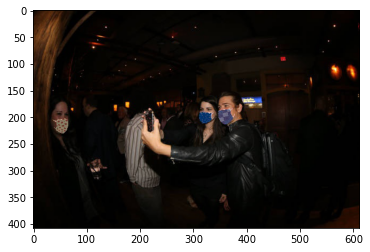

In [116]:
image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])*1/255
print(input_arr.shape)

#augmented_img = augmented_img * 255
print (input_arr)

plt.imshow(np.uint8(input_arr*255)[0])
plt.plot